# Natural Language Processing (NLP)
## Feature Extraction & Vectorizing


### Scope of this notebook:

### 1.  Data Inspection
### 2.  Add Sentiment Feature to data set
### 3.  Create Product Sentiment Reviews Dataset
### 4.  Tokenization, Normalization & Custom Stopword Filtering
### 5.  Extract the most common words
### 6.  Create "Bag of Words" data set
### 7.  Term Frequency-Inverse Document Frequency (TF-IDF)
### 8.  Split the Data into Training and Testing
### 9.  Balanced Random Forest Classifier

In [189]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [190]:
# read data source
df = pd.read_csv("Resources/helpful_clean_reviews_combined.csv")
df.head()

,key,stars,helpful_yes,helpful_no,text,rating
0,0_breyers,1,11,0,I am interested in the flavoring components us...,4.1
1,0_breyers,1,7,0,"Boy, was I surprised when I got my Bryers home...",4.1
2,0_breyers,1,8,0,I havent purchased this product in awhile and ...,4.1
3,0_breyers,1,4,0,The Natural Vanilla recipe change to include T...,4.1
4,0_breyers,5,21,2,I had the same issue with breyers. I finally f...,4.1


### 1. Data Inspection

In [191]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  3424
Columns  :  6

Features :  ['key', 'stars', 'helpful_yes', 'helpful_no', 'text', 'rating']

Missing values :   0

Unique values :  
 key             184
stars             5
helpful_yes      66
helpful_no       20
text           3419
rating           11
dtype: int64


In [192]:
# find missing values and view data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3424 non-null   object 
 1   stars        3424 non-null   int64  
 2   helpful_yes  3424 non-null   int64  
 3   helpful_no   3424 non-null   int64  
 4   text         3424 non-null   object 
 5   rating       3424 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 160.6+ KB


In [193]:
# Find null values
for column in df.columns:
    print(f"Column {column} has {df[column].isnull().sum()} null values")

Column key has 0 null values
Column stars has 0 null values
Column helpful_yes has 0 null values
Column helpful_no has 0 null values
Column text has 0 null values
Column rating has 0 null values


In [194]:
# Find duplicate entries
# duplicate entries are not telling us anything new  and can skew results
print(f"Duplicate entries: {(df.duplicated().sum()) * 2}")

Duplicate entries: 4


In [195]:
# drop duplicate entries
df.drop_duplicates(subset=['text'])

,key,stars,helpful_yes,helpful_no,text,rating
0,0_breyers,1,11,0,I am interested in the flavoring components us...,4.1
1,0_breyers,1,7,0,"Boy, was I surprised when I got my Bryers home...",4.1
2,0_breyers,1,8,0,I havent purchased this product in awhile and ...,4.1
3,0_breyers,1,4,0,The Natural Vanilla recipe change to include T...,4.1
4,0_breyers,5,21,2,I had the same issue with breyers. I finally f...,4.1
...,...,...,...,...,...,...
3419,9_hd,5,1,0,I tried the new flavor with layers and it was ...,4.9
3420,9_hd,5,1,0,"love this ice cream, taste fantastic!! will ne...",4.9
3421,9_hd,5,1,0,This is my favorite cream. Where can I find th...,4.9
3422,9_hd,5,1,0,The best tasting ice cream out there! It is ve...,4.9


In [196]:
# create data_df to hold new dataset without duplicates
df_data = pd.DataFrame(df)
df_data

,key,stars,helpful_yes,helpful_no,text,rating
0,0_breyers,1,11,0,I am interested in the flavoring components us...,4.1
1,0_breyers,1,7,0,"Boy, was I surprised when I got my Bryers home...",4.1
2,0_breyers,1,8,0,I havent purchased this product in awhile and ...,4.1
3,0_breyers,1,4,0,The Natural Vanilla recipe change to include T...,4.1
4,0_breyers,5,21,2,I had the same issue with breyers. I finally f...,4.1
...,...,...,...,...,...,...
3419,9_hd,5,1,0,I tried the new flavor with layers and it was ...,4.9
3420,9_hd,5,1,0,"love this ice cream, taste fantastic!! will ne...",4.9
3421,9_hd,5,1,0,This is my favorite cream. Where can I find th...,4.9
3422,9_hd,5,1,0,The best tasting ice cream out there! It is ve...,4.9


### 2.  Add Sentiment Feature to data set

Any review with 4 or more stars gets a value of 1 to reflect positve sentiment. 
Any review with 4 or less stars gets a value of 0 to reflect negative sentiment.

In [197]:
# add sentiment column to df_data
df_data['sentiment'] = pd.Series(dtype='int64')
df_data.head()

,key,stars,helpful_yes,helpful_no,text,rating,sentiment
0,0_breyers,1,11,0,I am interested in the flavoring components us...,4.1,NaN
1,0_breyers,1,7,0,"Boy, was I surprised when I got my Bryers home...",4.1,NaN
2,0_breyers,1,8,0,I havent purchased this product in awhile and ...,4.1,NaN
3,0_breyers,1,4,0,The Natural Vanilla recipe change to include T...,4.1,NaN
4,0_breyers,5,21,2,I had the same issue with breyers. I finally f...,4.1,NaN


In [198]:
# assign 1 for positive sentiment, 0 for negative
# if stars 4 or higher, sentiment is positive

def applyFunc(s):
    if s >= 4:
        return 1
    else:
        return 0

# populate column        
df_data['sentiment'] = df_data['stars'].apply(applyFunc)
df_data.head()

,key,stars,helpful_yes,helpful_no,text,rating,sentiment
0,0_breyers,1,11,0,I am interested in the flavoring components us...,4.1,0
1,0_breyers,1,7,0,"Boy, was I surprised when I got my Bryers home...",4.1,0
2,0_breyers,1,8,0,I havent purchased this product in awhile and ...,4.1,0
3,0_breyers,1,4,0,The Natural Vanilla recipe change to include T...,4.1,0
4,0_breyers,5,21,2,I had the same issue with breyers. I finally f...,4.1,1


In [199]:
# Create positive sentiment dataframe
# delete if not used in rest of notebook
# again, seeing output may drive inspiration for new ideas or provide clarity on the direction. 

df_positive_sentiment = df_data[df_data['sentiment'] ==1]
df_positive_sentiment

,key,stars,helpful_yes,helpful_no,text,rating,sentiment
4,0_breyers,5,21,2,I had the same issue with breyers. I finally f...,4.1,1
17,0_breyers,4,45,3,The taste of Breyers vanilla ice cream decline...,4.1,1
42,0_breyers,4,2,0,This product no longer has specks of vanilla i...,4.1,1
56,0_breyers,5,53,32,After trying Bryers Natural Vanilla Ice Cream ...,4.1,1
68,0_breyers,4,1,0,"Hi. My husband and I like the ice cream, but w...",4.1,1
...,...,...,...,...,...,...,...
3419,9_hd,5,1,0,I tried the new flavor with layers and it was ...,4.9,1
3420,9_hd,5,1,0,"love this ice cream, taste fantastic!! will ne...",4.9,1
3421,9_hd,5,1,0,This is my favorite cream. Where can I find th...,4.9,1
3422,9_hd,5,1,0,The best tasting ice cream out there! It is ve...,4.9,1


In [200]:
# Create negative sentiment dataframe
# delete if not used in rest of notebook

df_negative_sentiment = df_data[df_data['sentiment'] ==0]
df_negative_sentiment

,key,stars,helpful_yes,helpful_no,text,rating,sentiment
0,0_breyers,1,11,0,I am interested in the flavoring components us...,4.1,0
1,0_breyers,1,7,0,"Boy, was I surprised when I got my Bryers home...",4.1,0
2,0_breyers,1,8,0,I havent purchased this product in awhile and ...,4.1,0
3,0_breyers,1,4,0,The Natural Vanilla recipe change to include T...,4.1,0
5,0_breyers,1,4,0,I rarely eat ice cream these days but bought t...,4.1,0
...,...,...,...,...,...,...,...
3349,8_talenti,2,3,1,"I dont buy a lot of ice cream, gelato, or swee...",4.3,0
3352,8_talenti,3,3,0,The top layers are great. Tastes like cheeseca...,4.3,0
3358,8_talenti,3,2,1,I was really excited to try this flavor but wa...,4.3,0
3361,8_talenti,3,1,0,All of your flavors are such high quality and ...,4.3,0


### 3.  Create Product Sentiment Reviews Dataset

This is the helpful_cleaned_reviews_combined.csv with duplicates removed and sentiment column added.

In [201]:
# create product_sentiment_reviews.csv
df_data.to_csv("Resources/product_sentiment_reviews.csv", index=False)

### 4.  Tokenization, Normalization & Custom Stopword Filtering with NLTK

Here is where all the magic of splitting the reviews into individual words, putting each word into lower case, lemmatizing each to its base form, removing punctuations and excluding stop words occurs.

We perform this step with the NLTK library as it is the most popular in education and research for NLP.  

In [202]:
# create tokenizer dataframe
df_tokenize = pd.DataFrame(df_data)

In [203]:
# import the Tokenizer library
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer

# RegexpTokenizer will tokenize according to any regular expression assigned. 
# The regular expression r'\w+' matches any pattern consisting of one or more consecutive letters.
reTokenizer = RegexpTokenizer(r'\w+')



from nltk.corpus import stopwords
from string import punctuation
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [204]:
#stop_words

In [205]:
# collect all the words from all the reviews into one list

# initialize list to hold words
all_words = []


for i in range(len(df_tokenize['text'])):
    # separate review text into a list of words
    tokens = reTokenizer.tokenize(df_tokenize['text'][i])
    
    
    df_tokenize['text'][i] = []
    
    # iterate through tokens
    for word in tokens:
        # lower the case of each word
        word = word.lower()
        # exclude stop words
        if word not in stop_words:
            
            # Lemmatize words into a standard form and avoid counting the same word more than once
            word = lemmatizer.lemmatize(word)
            # add to list of words
            all_words.append(word)
            # append to text column of dataframe for appropriate row
            df_tokenize['text'][i].append(word)
            

### 5.  Bag of Words? Extract the most common words

"bag of words" and "most common words" is used interchangeably throughout the rest of this notebook. We will fix it to be consistent after everyone has mastered comfort with the code.

In [206]:
# Extract the most common words from the list of all_words.

from nltk import FreqDist

# sort all of the words in the all_words list by frequency count
all_words = FreqDist(all_words)
# Extract the 500 most common words from the all_words list
most_common_words = all_words.most_common(500)

# create a list of most common words without the frequency count
word_features = []
for w in most_common_words:
    word_features.append(w[0])

#print 
most_common_words

[('cream', 3175),
 ('ice', 3018),
 ('flavor', 2681),
 ('chocolate', 1419),
 ('love', 1123),
 ('like', 987),
 ('one', 909),
 ('taste', 857),
 ('favorite', 725),
 ('good', 676),
 ('best', 645),
 ('vanilla', 566),
 ('would', 547),
 ('pint', 534),
 ('ever', 518),
 ('time', 504),
 ('get', 470),
 ('creamy', 459),
 ('cookie', 456),
 ('store', 453),
 ('find', 432),
 ('delicious', 432),
 ('please', 431),
 ('great', 398),
 ('try', 390),
 ('really', 389),
 ('im', 383),
 ('butter', 383),
 ('tried', 379),
 ('sweet', 379),
 ('gelato', 373),
 ('perfect', 370),
 ('make', 368),
 ('chip', 352),
 ('product', 351),
 ('buy', 348),
 ('texture', 346),
 ('amazing', 344),
 ('caramel', 341),
 ('breyers', 339),
 ('new', 339),
 ('eat', 338),
 ('peanut', 337),
 ('ive', 334),
 ('first', 331),
 ('year', 327),
 ('much', 314),
 ('go', 308),
 ('dairy', 308),
 ('never', 305),
 ('bought', 285),
 ('dont', 266),
 ('every', 266),
 ('chunk', 264),
 ('back', 254),
 ('always', 252),
 ('better', 246),
 ('could', 240),
 ('even',

In [207]:
print ('There are ', len(all_words), 'unique words total in our text dataset.')
print ('There are ', len(most_common_words), 'unique words in the most common words list.')

There are  6153 unique words total in our text dataset.
There are  500 unique words in the most common words list.


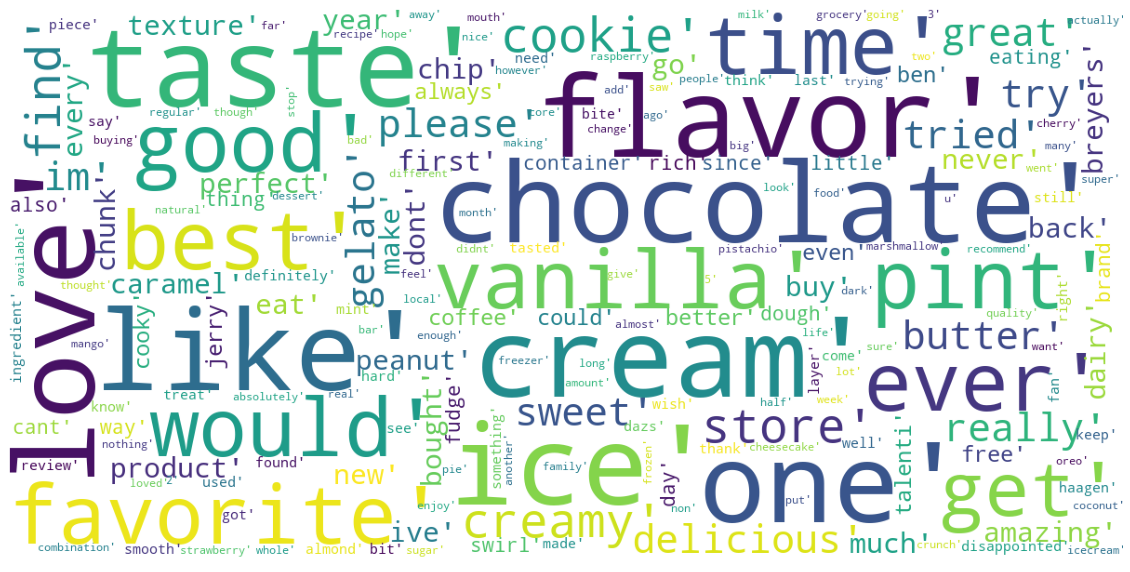

In [208]:
# WordCloud for Most Common Words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        # Chose 10 as random state. We can play with this.
        random_state=10    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(most_common_words)

#### 6.  Create "Bag of Words" data set

In [209]:
# create Bag of Words DataFrame
df_bagofwords = pd.DataFrame(df_tokenize)


In [210]:
# create column for bag of words
df_bagofwords['bag_of_words'] = ""
df_bagofwords.head()

,key,stars,helpful_yes,helpful_no,text,rating,sentiment,bag_of_words
0,0_breyers,1,11,0,"[interested, flavoring, component, used, notic...",4.1,0,
1,0_breyers,1,7,0,"[boy, surprised, got, bryers, home, discover, ...",4.1,0,
2,0_breyers,1,8,0,"[havent, purchased, product, awhile, surprised...",4.1,0,
3,0_breyers,1,4,0,"[natural, vanilla, recipe, change, include, ta...",4.1,0,
4,0_breyers,5,21,2,"[issue, breyers, finally, found, turkey, hill,...",4.1,1,


In [211]:
# iterate dataframe to populate bag of words column
for i in range(len(df_bagofwords['text'])):
    # initialize empty column    
    df_bagofwords['bag_of_words'][i] = []
    
    # iterate through df row by row
    for word in df_bagofwords['text'][i]:
        # if a word in 'text' is in the most common words
        # note: this is simply the "most_common_words" without the count column
        if word in word_features:
            # if it is, add it to the bag of words cell
            df_bagofwords['bag_of_words'][i].append(word)
            
             

In [212]:
df_bagofwords.head()

,key,stars,helpful_yes,helpful_no,text,rating,sentiment,bag_of_words
0,0_breyers,1,11,0,"[interested, flavoring, component, used, notic...",4.1,0,"[used, ingredient, list, vanilla, bean, vanill..."
1,0_breyers,1,7,0,"[boy, surprised, got, bryers, home, discover, ...",4.1,0,"[surprised, got, home, frozen, dairy, dessert,..."
2,0_breyers,1,8,0,"[havent, purchased, product, awhile, surprised...",4.1,0,"[havent, purchased, product, surprised, today,..."
3,0_breyers,1,4,0,"[natural, vanilla, recipe, change, include, ta...",4.1,0,"[natural, vanilla, recipe, change, gum, change..."
4,0_breyers,5,21,2,"[issue, breyers, finally, found, turkey, hill,...",4.1,1,"[issue, breyers, finally, found, natural, ice,..."


In [213]:
# Example to compare text vs bag of words
# set example variable equal to the review row you'd like to see
example = 7

print('text: ', df_bagofwords['text'][example])
print('\nbag_of_words: ',df_bagofwords['bag_of_words'][example])

text:  ['upset', '1', '5qt', 'container', 'natural', 'vanilla', 'two', 'different', 'store', 'lacked', 'little', 'black', 'speck', 'come', 'love', 'expect']

bag_of_words:  ['1', 'container', 'natural', 'vanilla', 'two', 'different', 'store', 'little', 'come', 'love']


### 7.  Term Frequency-Inverse Document Frequency (TF-IDF)

In [214]:
# import dependencies
from sklearn.feature_extraction.text import TfidfVectorizer

# create new DataFrame to hold encoded values 
df_tfidf_text = pd.DataFrame(df_bagofwords)

# convert text list to string and create string column
# Required for vectorizer. Running on a list will yield an error.
# https://stackoverflow.com/questions/45306988/column-of-lists-convert-list-to-string-as-a-new-column
df_tfidf_text['bag_of_words_str'] = df_tfidf_text['bag_of_words'].apply(lambda x: ','.join(map(str, x)))

df_tfidf_text.head()

,key,stars,helpful_yes,helpful_no,text,rating,sentiment,bag_of_words,bag_of_words_str
0,0_breyers,1,11,0,"[interested, flavoring, component, used, notic...",4.1,0,"[used, ingredient, list, vanilla, bean, vanill...","used,ingredient,list,vanilla,bean,vanilla,natu..."
1,0_breyers,1,7,0,"[boy, surprised, got, bryers, home, discover, ...",4.1,0,"[surprised, got, home, frozen, dairy, dessert,...","surprised,got,home,frozen,dairy,dessert,even,i..."
2,0_breyers,1,8,0,"[havent, purchased, product, awhile, surprised...",4.1,0,"[havent, purchased, product, surprised, today,...","havent,purchased,product,surprised,today,find,..."
3,0_breyers,1,4,0,"[natural, vanilla, recipe, change, include, ta...",4.1,0,"[natural, vanilla, recipe, change, gum, change...","natural,vanilla,recipe,change,gum,change,textu..."
4,0_breyers,5,21,2,"[issue, breyers, finally, found, turkey, hill,...",4.1,1,"[issue, breyers, finally, found, natural, ice,...","issue,breyers,finally,found,natural,ice,cream,..."


In [215]:
# create tokenized_text_features.csv
# finally in the format needed for vectorizing our features
# the bag_of_words column as a string which is required for vectorizing
df_tfidf_text.to_csv("Resources/tokenized_text_features.csv", index=False)

In [216]:
# get 'text' term frequencies weighted by their relative importance (IDF)
tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english')

# create variable to hold independent features and TFIDF
x = df_tfidf_text['bag_of_words_str']


# Fit and transform independent features
xtfidf = tfidf.fit_transform(x)

# Create encoded TFIDF vector for bag of words
tfdif_bagOfWords_df = pd.DataFrame(data = xtfidf.toarray(),
                        # set column header as feature names           
                        columns = tfidf.get_feature_names())

tfdif_bagOfWords_df.head()

,10,able,absolute,absolutely,actually,add,added,addicted,ago,ahoy,...,world,worth,wow,write,wrong,year,yes,youre,yum,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
print ('\nFeatures : ', tfdif_bagOfWords_df.columns.tolist())


Features :  ['10', 'able', 'absolute', 'absolutely', 'actually', 'add', 'added', 'addicted', 'ago', 'ahoy', 'almond', 'amazing', 'anymore', 'apple', 'area', 'artificial', 'ate', 'available', 'away', 'awesome', 'bad', 'baked', 'balance', 'banana', 'bar', 'barely', 'base', 'batch', 'bean', 'believe', 'ben', 'best', 'better', 'big', 'bigger', 'bit', 'bite', 'blend', 'bought', 'bourbon', 'box', 'brand', 'breyers', 'bring', 'brownie', 'butter', 'buy', 'buying', 'cake', 'calorie', 'came', 'caramel', 'carb', 'carbs', 'carry', 'carton', 'change', 'changed', 'cheesecake', 'cherry', 'chip', 'chocolate', 'choice', 'chunk', 'cinnamon', 'coconut', 'coffee', 'cold', 'com', 'combination', 'combo', 'come', 'company', 'completely', 'cone', 'consistency', 'consumer', 'container', 'cookie', 'cooky', 'core', 'couple', 'covered', 'cracker', 'craving', 'cream', 'creamy', 'crunch', 'crunchy', 'cup', 'customer', 'dairy', 'dark', 'day', 'dazs', 'decadent', 'decided', 'definitely', 'delicious', 'delight', 'des

In [218]:
# Rank top 20 terms from TFID in order of signifigance score
# https://stackoverflow.com/questions/45805493/sorting-tfidfvectorizer-output-by-tf-idf-lowest-to-highest-and-vice-versa

terms = tfidf.get_feature_names()

# sum tfidf frequency of each term through documents
sums = xtfidf.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','significance'])
term_rank = ranking.sort_values('significance', ascending=False)

term_rank[:20]


,term,significance
85,cream,286.489907
186,ice,277.188113
140,flavor,270.473062
61,chocolate,176.530416
226,love,169.931561
134,favorite,126.397171
210,like,125.314723
31,best,123.825966
359,taste,123.233303
158,good,116.146262


In [219]:
# Merge tfidf features and drop the originals

df_tfidf_text = df_tfidf_text.merge(tfdif_bagOfWords_df,left_index=True, right_index=True)
df_tfidf_text = df_tfidf_text.drop(["text","bag_of_words","bag_of_words_str"], axis=1)
df_tfidf_text.head()

,key,stars,helpful_yes,helpful_no,rating,sentiment,10,able,absolute,absolutely,...,world,worth,wow,write,wrong,year,yes,youre,yum,yummy
0,0_breyers,1,11,0,4.1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0_breyers,1,7,0,4.1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0_breyers,1,8,0,4.1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0_breyers,1,4,0,4.1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0_breyers,5,21,2,4.1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 8.  Split the Data into Training and Testing

In [220]:
# Segment the features from the target
y = df_tfidf_text["sentiment"]
X = df_tfidf_text.drop(["key","stars","helpful_yes","helpful_no","rating","sentiment"], axis=1)

In [221]:
X.describe()

,10,able,absolute,absolutely,actually,add,added,addicted,ago,ahoy,...,world,worth,wow,write,wrong,year,yes,youre,yum,yummy
count,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,...,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000
mean,0.005549,0.005273,0.005765,0.011227,0.006648,0.006658,0.005082,0.004520,0.008619,0.004503,...,0.007107,0.004558,0.004575,0.003007,0.004125,0.018397,0.003074,0.003047,0.003596,0.005809
std,0.049038,0.040194,0.048539,0.058675,0.040149,0.041007,0.040540,0.038915,0.050413,0.040901,...,0.050449,0.041063,0.044570,0.032104,0.035525,0.069030,0.032660,0.030351,0.041380,0.044180
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.928857,0.674291,0.887339,0.651532,0.455309,0.505587,0.748950,0.813785,0.730124,0.608328,...,0.602960,0.889288,0.816248,0.731636,0.624247,0.666159,0.785823,0.692731,0.842513,0.634024


In [222]:
# Check the balance of our target values
y.value_counts()

1    2739
0     685
Name: sentiment, dtype: int64

In [223]:
# Normal train-test split
from sklearn.model_selection import train_test_split
from collections import Counter

# 75% split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)
Counter(y_train)

Counter({1: 2057, 0: 511})

In [224]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2568, 417)
(856, 417)
(2568,)
(856,)


### 9.  Balanced Random Forest Classifier

In [225]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 

In [226]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [227]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test)

In [228]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(str('Balanced Random Forest'))
print(str('Accuracy Score'))
print((acc_score))

Balanced Random Forest
Accuracy Score
0.7651869158878505


In [229]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Neg Sentiment", "Actual Pos Sentiment"], columns=["Predicted Neg Sentiment", "Predicted Pos Sentiment"])

cm_df

print(str('Balanced Random Forest'))
print(str('Confusion Matrix'))
print(cm_df)

Balanced Random Forest
Confusion Matrix
                      Predicted Neg Sentiment  Predicted Pos Sentiment
Actual Neg Sentiment                      150                       24
Actual Pos Sentiment                      177                      505


In [230]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(str('Balanced Random Forest'))
print(str('Imbalanced Classification Report'))
print(classification_report_imbalanced(y_test, predictions))

Balanced Random Forest
Imbalanced Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.46      0.86      0.74      0.60      0.80      0.65       174
          1       0.95      0.74      0.86      0.83      0.80      0.63       682

avg / total       0.85      0.77      0.84      0.79      0.80      0.63       856



In [231]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
feature_importance = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
feature_importance

[(0.041157708829910405, 'disappointed'),
 (0.028948902182373802, 'love'),
 (0.027405979960501783, 'best'),
 (0.022006239790729087, 'taste'),
 (0.020822530188481823, 'like'),
 (0.019960635583354813, 'vanilla'),
 (0.01719809286548308, 'used'),
 (0.016903925216234215, 'flavor'),
 (0.016359805731422605, 'perfect'),
 (0.015376806285808607, 'delicious'),
 (0.014109497719704338, 'favorite'),
 (0.013603373174743019, 'disappointing'),
 (0.01192978422129916, 'ice'),
 (0.011919247478194318, 'cream'),
 (0.011517651773841724, 'recipe'),
 (0.010403220446838243, 'amazing'),
 (0.009412197506012547, 'chocolate'),
 (0.0084239930109965, 'changed'),
 (0.008350276603617151, 'store'),
 (0.008204792784682492, 'bad'),
 (0.008064595156469198, 'creamy'),
 (0.00801383501718746, 'bought'),
 (0.007713203637104718, 'great'),
 (0.00719102277508481, 'good'),
 (0.006960863881556014, 'change'),
 (0.006707972348151277, 'product'),
 (0.0066776448343403415, 'purchased'),
 (0.0064902122711841615, 'anymore'),
 (0.0064307972

In [232]:
print(str('Top 10 Features'))
print(str('Ranked by Importance'))
display(feature_importance[:10])

Top 10 Features
Ranked by Importance


[(0.041157708829910405, 'disappointed'),
 (0.028948902182373802, 'love'),
 (0.027405979960501783, 'best'),
 (0.022006239790729087, 'taste'),
 (0.020822530188481823, 'like'),
 (0.019960635583354813, 'vanilla'),
 (0.01719809286548308, 'used'),
 (0.016903925216234215, 'flavor'),
 (0.016359805731422605, 'perfect'),
 (0.015376806285808607, 'delicious')]

In [233]:
print(str('Bottom 10 Features'))
print(str('Ranked by Importance'))
display(feature_importance[-10:])

Bottom 10 Features
Ranked by Importance


[(0.00020500936659693, 'carry'),
 (0.00020353315371878989, 'easy'),
 (0.00018314169432117572, 'mean'),
 (0.0001788477506493664, 'yes'),
 (0.00016193950998495774, 'delight'),
 (0.00016132759892550138, 'gave'),
 (0.00016023749234125466, 'diet'),
 (0.00010528680472881623, 'soon'),
 (0.00010069299427110465, 'white'),
 (8.669624762423025e-05, 'phish')]